# **Second Asigment: Machine Learning**



*   Armando Miguel Tapia Meza
*   Erick Jose Ruiz Acpsta



## **Pregunta de Investigacion**

¿Existe una relacion inherente entre la forma lexica y gramatica en que extructuran sus mensajes los politicos españoles pertenecientes a una misma corriente o partido politico?

## **Hipotesis**

Las personas pertenecientes a un mismo partido politico tienden a usar un conjunto de frases y palabras en comun a la hora de escribir en redes sociales, lo que permite identificarlos y clasificarlos.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import TweetTokenizer
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
from sklearn.pipeline import FeatureUnion
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from text_processing import TextProcessing as tp
from sklearn.svm import LinearSVC

# **Preprocesamiento**

In [ ]:
# se cargan los datos
df = pd.read_csv('tweets_politica_kaggle.csv', delimiter='\t')

In [ ]:
# informacion general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130039 entries, 0 to 130038
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cuenta     130039 non-null  object 
 1   partido    130029 non-null  object 
 2   timestamp  130029 non-null  float64
 3   tweet      130029 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.0+ MB


In [ ]:
# vista inicial de los primeros registros
df.head()

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...


In [ ]:
# verificacion defilas repetidas
df.duplicated().sum()

383

In [ ]:
# eliminacion de filas repetidas
df = df.drop_duplicates()
df.shape[0]

129656

In [ ]:
#verificacion de valores faltantes por columna
df.isna().sum()

cuenta       0
partido      1
timestamp    1
tweet        1
dtype: int64

In [ ]:
# eliminacion de filas con valores faltantes en al menos 3 columnas
df = df.dropna(thresh = 3)
df.shape[0]

129655

In [ ]:
# estadisticos categoricos para la columna objetivo 
df['partido'].describe()

count     129655
unique         5
top         psoe
freq       28786
Name: partido, dtype: object

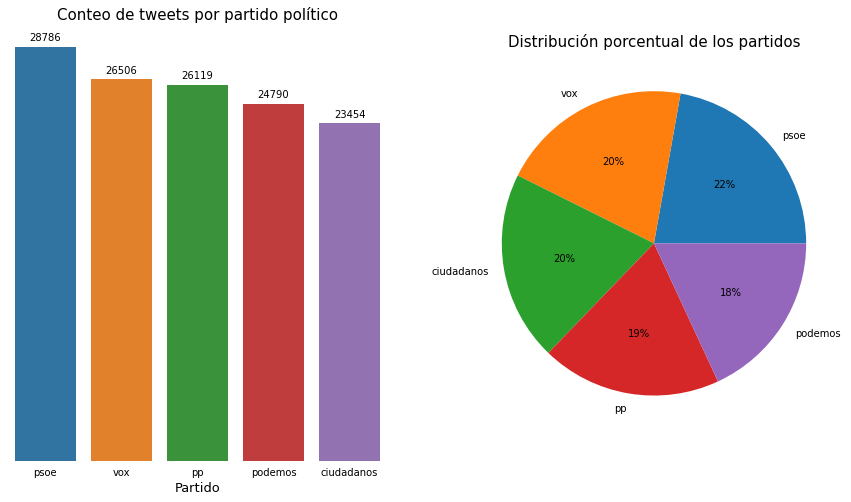

In [ ]:
# gráficas y distribuciones de frecuencia
fig, axes = plt.subplots(1,2,figsize=(15,8))
pos = np.arange(len(df['partido'].unique()[:5]))
bar = sns.countplot(ax=axes[0],x='partido',data=df ,order = df['partido'].value_counts().index)
axes[0].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
for p in bar.patches:
    bar.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
for pos in ['right', 'top', 'bottom', 'left']:
    axes[0].spines[pos].set_visible(False)
bar.set_ylabel('')
bar.set_xlabel('Partido', size=13)
bar.set_title('Conteo de tweets por partido político', size=15)
pie = axes[1].pie(x=df['partido'].value_counts(),labels = df['partido'].unique()[:5],autopct='%.0f%%')
_=axes[1].set_title('Distribución porcentual de los partidos', size=15)

In [ ]:
# Division de datos de entrenamiento y prueba usando muestreo aleatorio estratificado
from stratified_sampling import random_stratified_sampling

x_train, y_train, x_test, y_test = random_stratified_sampling(df,y='partido',test_size=0.2)

In [ ]:
# verificacion del balanceo de las clases para las pruebas
y_test.value_counts()

vox           5186
podemos       5186
psoe          5186
pp            5186
ciudadanos    5186
Name: partido, dtype: int64

In [ ]:
# funcion para limpiar el contenido de los tweets
def remove_mentions_hastag_urls(content):
  clean_tweet = tp.transformer(content)
  clean_tweet = re.sub("mention","", clean_tweet)
  clean_tweet = re.sub("emoji","", clean_tweet)
  clean_tweet = re.sub("hastag", "" , clean_tweet)
  return clean_tweet
# aplicamos la funcion para los datos de entrenamiento y prueba 
x_train['clean_tweet'] = x_train.apply(lambda row: remove_mentions_hastag_urls(row['tweet']), axis=1)
x_test['clean_tweet'] = x_test.apply(lambda row: remove_mentions_hastag_urls(row['tweet']), axis=1)

In [ ]:
# tokenizacion de los tweets
x_train['tokenized_tweet']  = x_train.apply(lambda row: TweetTokenizer().tokenize(row['clean_tweet']), axis=1)
x_test['tokenized_tweet']  = x_test.apply(lambda row: TweetTokenizer().tokenize(row['clean_tweet']), axis=1)

In [ ]:
# vista preliminar de la matriz de caracteristicas
x_train

,cuenta,timestamp,tweet,clean_tweet,tokenized_tweet
0,a34133350b0605cb24081843f63176ca,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...,buen animo para esta primavera que inici...,"[buen, animo, para, esta, primavera, que, inic..."
1,a34133350b0605cb24081843f63176ca,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...,nuevos duenos para las renovables. en ese mom...,"[nuevos, duenos, para, las, renovables, ., en,..."
2,a34133350b0605cb24081843f63176ca,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...,el diferencial de precios energeticos con a...,"[el, diferencial, de, precios, energeticos, co..."
3,a34133350b0605cb24081843f63176ca,1.364155e+09,"""Cospedal: las crisis ya no afectan a España. ...",cospedal las crisis ya no afectan a espana. gu...,"[cospedal, las, crisis, ya, no, afectan, a, es..."
4,a34133350b0605cb24081843f63176ca,1.364202e+09,“@ventonoso: España importa ya energía de Port...,espana importa ya energia de portugal porque ...,"[espana, importa, ya, energia, de, portugal, p..."
...,...,...,...,...,...
103720,b4b003b4349b78f094d7018c2fdbb43a,1.633250e+09,Con la presencia de Rajoy y Feijoo no hacia fa...,con la presencia de rajoy y feijoo no hacia fa...,"[con, la, presencia, de, rajoy, y, feijoo, no,..."
103721,1e826d8471835f7feb02f8028b736ebb,1.633250e+09,"“Querido Pablo, nos complace tu voluntad de re...",querido pablo nos complace tu voluntad de revi...,"[querido, pablo, nos, complace, tu, voluntad, ..."
103722,aeaa6ce266f823338e7d2222032a9edd,1.633250e+09,"Quiero reivindicar la buena política, la de fr...",quiero reivindicar la buena politica la de fre...,"[quiero, reivindicar, la, buena, politica, la,..."
103723,aeaa6ce266f823338e7d2222032a9edd,1.633250e+09,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...,el pasado viernes se cumplio el aniversario de...,"[el, pasado, viernes, se, cumplio, el, anivers..."


# **Extraccion de caracteristicas**

Una vez terminado el preprocesamiento de los datos procedemos a la extraccion de caracteristicas. Para este caso en particular decidimos elegir dos tecnicas, la primera es TF-IDF y la segunda es Bag of N-grams.

En cuanto al detalle de los ngrams elegimos usar unigramas y bigramas.

En una primera iteracion decidimos usar solamente bigramas, pero en busca de un mejorar las metricas, probamos con unigramas y bigramas obteniendo que el tiempo de entrenamiento del clasificador softmax se disparo al doble, pero el rendimiento del modelo reflejado en las metricas esocogidas para su evaluacion solo mejoro en alredor de un 3%. El acurracy en particular solo paso de 66,87 a 69,75.

Basado en esos, decidimos volver a usar unigramas y bigramas e intentamos reducir la cantidad de caracteristicas eliminando palabras altamente repetitivas y que aportan poco valor, como lo son las stopwords. Entonces el acurracy paso a 69.64, un valor bastante mayor que la primera iteracion pero menor que la segunda iteracion, aunque el tiempo en esta tercera iteracion fue un poco menor que el de la segunda iteracion.

In [ ]:
tfidf_vector = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
bofngra_vector = CountVectorizer(analyzer='word', ngram_range=(1, 2))

Utulizaremos features union para concatenar las caracteriticas obtenidas por los dos metodos

In [ ]:
features_union = FeatureUnion([
    ('bofngra_vector', bofngra_vector),
    ('tfidf_vector', tfidf_vector)
])

In [ ]:
features_union.fit(x_train['clean_tweet'])

FeatureUnion(n_jobs=None,
             transformer_list=[('bofngra_vector',
                                CountVectorizer(analyzer='word', binary=False,
                                                decode_error='strict',
                                                dtype=<class 'numpy.int64'>,
                                                encoding='utf-8',
                                                input='content', lowercase=True,
                                                max_df=1.0, max_features=None,
                                                min_df=1, ngram_range=(1, 2),
                                                preprocessor=None,
                                                stop_words=None,
                                                strip_accents=None,
                                                token_pattern='(?u)\\b\\w\\w+\\b',
                                                toke...
                                                dtype=

Aplicamos la transformacion tanto al dataset de entrenamiento como al de pruebas

In [ ]:
x_train = features_union.transform(x_train['clean_tweet'])
x_test = features_union.transform(x_test['clean_tweet'])

In [ ]:
x_train

<103725x1059589 sparse matrix of type '<class 'numpy.float64'>'
	with 9365521 stored elements in Compressed Sparse Row format>

Nos aseguramos de que los dataset que contienen los targets tanto de entrenamiento como de prueba esten balanceados

In [ ]:
print('Muestra de entrenamiento:', sorted(Counter(y_train).items()))

Muestra de entrenamiento: [('ciudadanos', 18268), ('podemos', 19604), ('pp', 20933), ('psoe', 23600), ('vox', 21320)]


In [ ]:
print('Muestra de prueba:', sorted(Counter(y_test).items()))

Muestra de prueba: [('ciudadanos', 5186), ('podemos', 5186), ('pp', 5186), ('psoe', 5186), ('vox', 5186)]


In [ ]:
# decidimos hacer oversampler solamente del set de entrenamiento porque el de prueba ya estaba perfectamente balanceado
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Sobremuestra de entrenamiento:', sorted(Counter(y_train).items()))

Sobremuestra de entrenamiento: [('ciudadanos', 23600), ('podemos', 23600), ('pp', 23600), ('psoe', 23600), ('vox', 23600)]


#**Entrenamiento**

In [ ]:
kfold = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

In [ ]:
accuracies_scores_smax, accuracies_scores_svm = [], []
recalls_scores_smax, recalls_scores_svm = [], [] 
precisions_scores_smax, precisions_scores_svm = [], []
f1_scores_smax, f1_scores_svm = [], []

Inicializamos el primer clasificador que vamos a usar: **Softmax**

In [ ]:
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=2000)

Inicializamos el segundo clasificador, usaremos: **Support Vector Machine**

In [ ]:
clf = LinearSVC(C=0.1,max_iter=6000)

## Entrenamiento Softmax

In [ ]:
for train_index, test_index in kfold.split(x_train, y_train):

  data_train = x_train[train_index]
  target_train = y_train[train_index]
    
  data_test = x_train[test_index]
  target_test = y_train[test_index]

  softmax.fit(data_train, target_train)
  predict = softmax.predict(data_test)

  # Accuracy
  accuracy = accuracy_score(target_test, predict)
  accuracies_scores_smax.append(accuracy)

  # Recall
  recall = recall_score(target_test, predict, average='macro')
  recalls_scores_smax.append(recall)

  # Precision
  precision = precision_score(target_test, predict, average='weighted')
  precisions_scores_smax.append(precision)

  # F1
  f1 = f1_score(target_test, predict, average='weighted')
  f1_scores_smax.append(f1)

In [ ]:
average_smax_recall = round(np.mean(recalls_scores_smax) * 100, 2)
average_smax_precision = round(np.mean(precisions_scores_smax) * 100, 2)
average_smax_f1 = round(np.mean(f1_scores_smax) * 100, 2)
average_smax_accuracy = round(np.mean(accuracies_scores_smax) * 100, 2)

In [ ]:
y_predict = []
for features in x_test:
    features = features.reshape(1, -1)
    value = softmax.predict(features)[0]
    y_predict.append(value)

classification = classification_report(y_test, y_predict)
confusion = confusion_matrix(y_predict, y_test)

In [ ]:
print(f'Acurracy Softmax: {average_smax_accuracy}')
print(f'F1-score Softmax: {average_smax_f1}')
print(f'Precision Softmax: {average_smax_precision}')
print(f'Recall Softmax: {average_smax_recall}\n')
print('*** Classification Report***\n')
print(classification + '\n')
print('*** Matriz de confusion***\n')
print(confusion)

Acurracy Softmax: 69.65
F1-score Softmax: 69.64
Precision Softmax: 69.69
Recall Softmax: 69.66

*** Classification Report***

              precision    recall  f1-score   support

  ciudadanos       0.68      0.58      0.62      5186
     podemos       0.69      0.66      0.67      5186
          pp       0.58      0.61      0.60      5186
        psoe       0.61      0.65      0.63      5186
         vox       0.63      0.67      0.65      5186

    accuracy                           0.63     25930
   macro avg       0.64      0.63      0.63     25930
weighted avg       0.64      0.63      0.63     25930


*** Matriz de confusion***

[[3007  260  566  269  352]
 [ 342 3408  298  553  340]
 [ 817  367 3175  515  571]
 [ 481  663  590 3349  447]
 [ 539  488  557  500 3476]]


## Entrenamiento SVM

In [ ]:
for train_index, test_index in kfold.split(x_train, y_train):

  data_train = x_train[train_index]
  target_train = y_train[train_index]
    
  data_test = x_train[test_index]
  target_test = y_train[test_index]

  clf.fit(data_train, target_train)
  predict = clf.predict(data_test)

  # Accuracy
  accuracy = accuracy_score(target_test, predict)
  accuracies_scores_svm.append(accuracy)

  # Recall
  recall = recall_score(target_test, predict, average='macro')
  recalls_scores_svm.append(recall)

  # Precision
  precision = precision_score(target_test, predict, average='weighted')
  precisions_scores_svm.append(precision)

  # F1
  f1 = f1_score(target_test, predict, average='weighted')
  f1_scores_svm.append(f1)

In [ ]:
average_svm_recall = round(np.mean(recalls_scores_svm) * 100, 2)
average_svm_precision = round(np.mean(precisions_scores_svm) * 100, 2)
average_svm_f1 = round(np.mean(f1_scores_svm) * 100, 2)
average_svm_accuracy = round(np.mean(accuracies_scores_svm) * 100, 2)

In [ ]:
y_predict = []
for features in x_test:
    features = features.reshape(1, -1)
    value = clf.predict(features)[0]
    y_predict.append(value)

classification = classification_report(y_test, y_predict)
confusion = confusion_matrix(y_predict, y_test)

In [ ]:
print(f'Acurracy SVM: {average_svm_accuracy}')
print(f'F1-score SVM: {average_svm_f1}')
print(f'Precision SVM: {average_svm_precision}')
print(f'Recall SVM: {average_svm_recall}\n')
print('*** Classification Report***\n')
print(classification + '\n')
print('*** Matriz de confusion***\n')
print(confusion)

Acurracy SVM: 70.47
F1-score SVM: 70.48
Precision SVM: 70.67
Recall SVM: 70.47

*** Classification Report***

              precision    recall  f1-score   support

  ciudadanos       0.68      0.58      0.62      5186
     podemos       0.71      0.68      0.69      5186
          pp       0.62      0.60      0.61      5186
        psoe       0.62      0.65      0.63      5186
         vox       0.61      0.71      0.65      5186

    accuracy                           0.64     25930
   macro avg       0.65      0.64      0.64     25930
weighted avg       0.65      0.64      0.64     25930


*** Matriz de confusion***

[[3000  237  585  296  321]
 [ 340 3529  273  526  328]
 [ 736  285 3116  439  458]
 [ 472  621  546 3349  411]
 [ 638  514  666  576 3668]]


# **Conclusión**
Realizados los entrenamientos y las pruebas podemos observar que ambos modelos tanto regresión logística como maquina de soporte vectorial 
dan unos buenos puntajes para las métricas evaluadas, sin embargo, la máquina de soporte vectorial es en promedio un 0.086% más eficiente 
en promedio en todas las métricas evaluadas. Ademas de que los tiempos de entrenamiento para la maquina vectorial se vieron disminuidos 
sustancialmente.
